In [2]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import qutip as quit
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve)
from qutip.measurement import measure_observable, measurement_statistics
from qutip.expect import expect
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec
#Add util to the path
import sys
sys.path.append('../util')
sys.path.append('../')

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
#import savgol:
from scipy.signal import savgol_filter
from fitting_functions_ZNE import third_no_first_ZNE, order_poly_ZNE, order_poly_instance, converge_ZNE_order, gaussian_ZNE, converge_ZNE_loocv


from tqdm import tqdm
from qutip import (about, basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz, tensor, mcsolve, sesolve, mesolve)
from basic_TFIM_funcs import get_s_lists
from joblib import Parallel, delayed
from functions_util import cetina_thermal_exp, cetina_envelope_exp,calibrate_sim_Omegas
from samplers_util import thermal_rejection

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


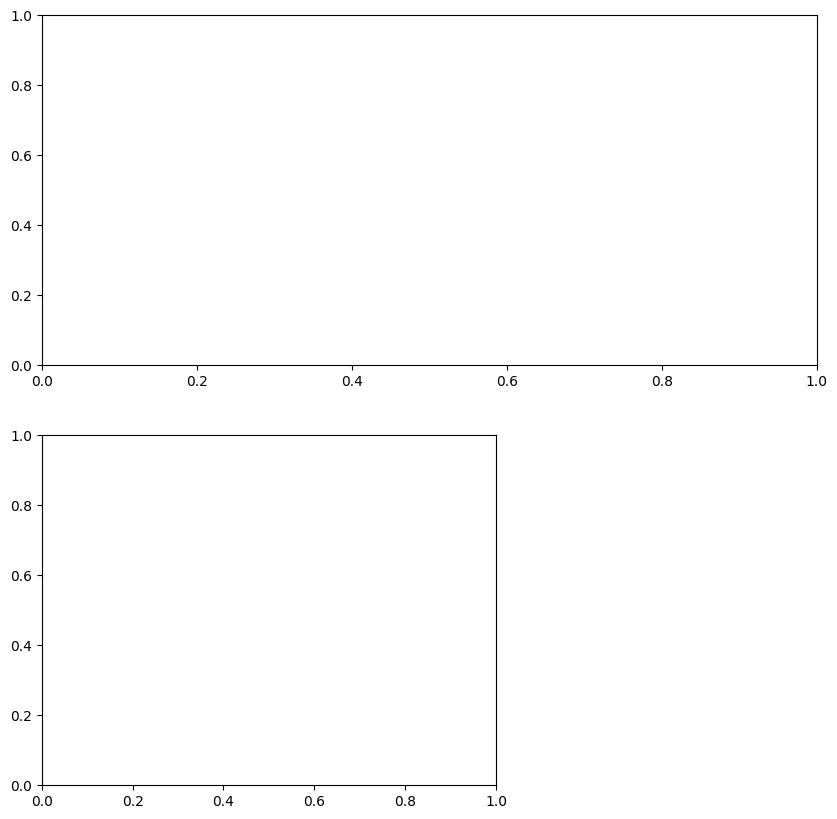

In [6]:
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2,5)
ax_1 = fig.add_subplot(gs[0,:])
ax_2 = fig.add_subplot(gs[1,0:3])

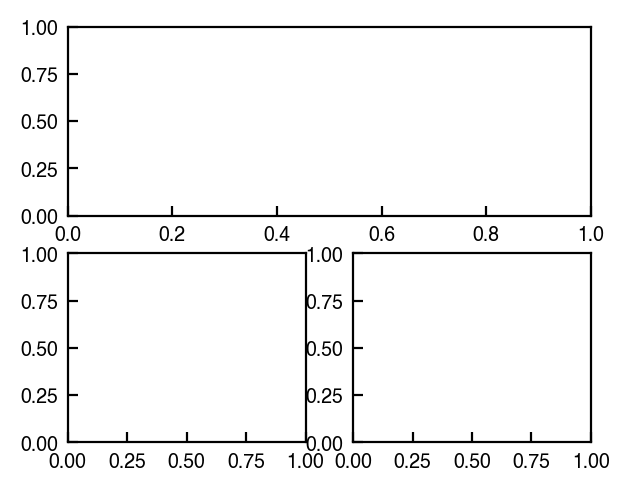

In [ ]:
import matplotlib as mpl

columns = 1
rows = 2
#scol=(3+3/8) #single column width of PRL,
#dcol=2*scol # double column,
#size_col = [scol, dcol][columns-1]
#size_row = [scol, dcol][rows-1]
mmtoinch = 1/25.4
scol = 88 * mmtoinch
dcol = 180 * mmtoinch
size_col = [scol, dcol][columns-1]
if columns == 1:
    size_row = scol*rows
else:
    size_row = dcol*rows

fullwidth=6.3,
from matplotlib import cm
gr=(np.sqrt(5.0) - 1.0) / 2.0 #golden ratio,
cm_subsection = np.linspace(0.2, 1.0, 5)
Reds = [ cm.Reds(x) for x in cm_subsection ]
mpl.rcParams.update({
    "ytick.direction": "in",
    "xtick.direction": "in",
    "axes.labelpad": 0,
    "font.size": 7,
    "legend.frameon": False,
    "figure.dpi":200,
    "figure.figsize": [size_col, size_row * gr],
    "font.family": "Helvetica",
    #"axes.prop_cycle": cycler('color', palettable.colorbrewer.qualitative.Dark2_8.mpl_colors)
    # "axes.prop_cycle": cycler('color', palettable.colorbrewer.sequential.Reds_9.mpl_colors[1:])
})
fig = plt.figure()
gs = gridspec.GridSpec(3,2)  # 2x2 grid
ax_a = fig.add_subplot(gs[:2])
ax_bi = fig.add_subplot(gs[2])
ax_bii = fig.add_subplot(gs[3])



In [3]:
#Load in the Rydberg data:
stagmag_averaged = np.load("stagmag_averaged.npy")
thetas = np.load("thetas.npy")
times = np.load("times.npy")
print(stagmag_averaged.shape)
print(times.shape)
#indexed as [theta, time] with sizes 100, 500

cmap = cm.get_cmap('Reds', 100)
#only use the range 0.5 - 1
colors = cmap(np.linspace(0.3, 1, 100))
baseline = 0.005
#Get the index in thetas closest to baseline:
baseline_index = np.argmin(np.abs(thetas - baseline))
factors = [1, 1.1, 1.3, 1.6, 2, 2.5]#, 3, 3.5, 4, 4.5, 5]
#Get the indexes of the factors * the baseline
indexes = [np.argmin(np.abs(thetas - baseline*factor)) for factor in factors]
indexes_mask = [i in indexes for i in range(len(thetas))]
ax_a.plot(times, stagmag_averaged[0], color='black', label=r"Noise Free", ls="--")
for index in indexes:
    ax_a.plot(times, stagmag_averaged[index], color=colors[index], lw=0.6)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(np.array(factors)*baseline)))
sm.set_array([])
#Add a label to the color bar:
cbar = fig.colorbar(sm, ax=ax_a)
#ax_a.plot(times, stagmag_averaged[-1], color=colors[-1], label=r"$\theta = {}$".format(thetas[-1]))

(100, 500)
(500,)


/var/folders/vf/9t237r796tb0tg2rrtljdd940000gn/T/ipykernel_74248/3282666539.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds', 100)


In [4]:
#Compute the ZNE data matrix:
ZNE_function = lambda x, y: converge_ZNE_loocv(x, y, debug=False)
#
try: 
    ZNE_data
except:
    ZNE_data = np.zeros(len(times))
    ZNE_functions = []
    #indexes_mask=[i > baseline_index for i in range(len(thetas))]
    for i in tqdm(range(len(times))):
        temp_function = ZNE_function(thetas[indexes_mask], stagmag_averaged[:, i][indexes_mask])#, weights=[1, 1, 1])
        ZNE_data[i] = temp_function(0)
        ZNE_functions.append(temp_function)
current_ylims = ax_a.get_ylim()
ax_a.plot(times, ZNE_data, color="blue", label="ZNE", zorder=-1)#, linestyle="--")


  0%|          | 0/500 [00:00<?, ?it/s]/Users/thomassteckmann/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|██████████| 500/500 [00:05<00:00, 84.37it/s]


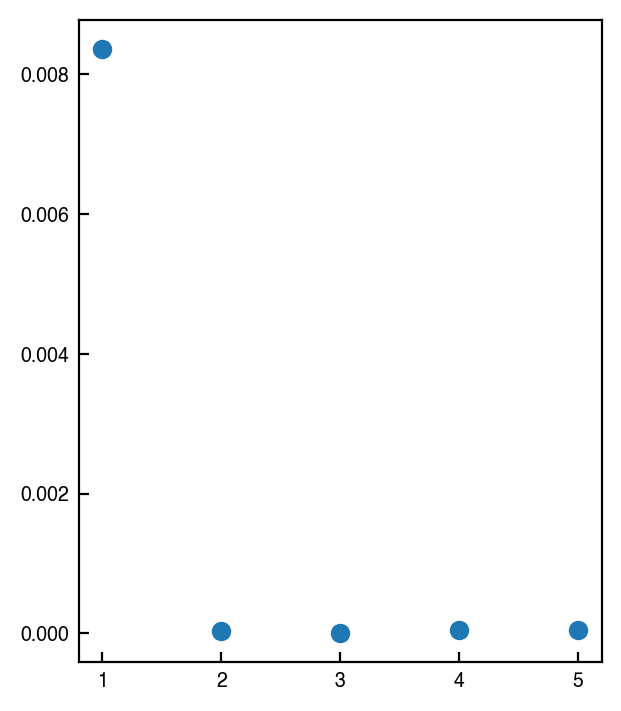

0.21400878906794896 + 0.0·x¹ - 522.2492775676076·x² + 13719.9091241208·x³


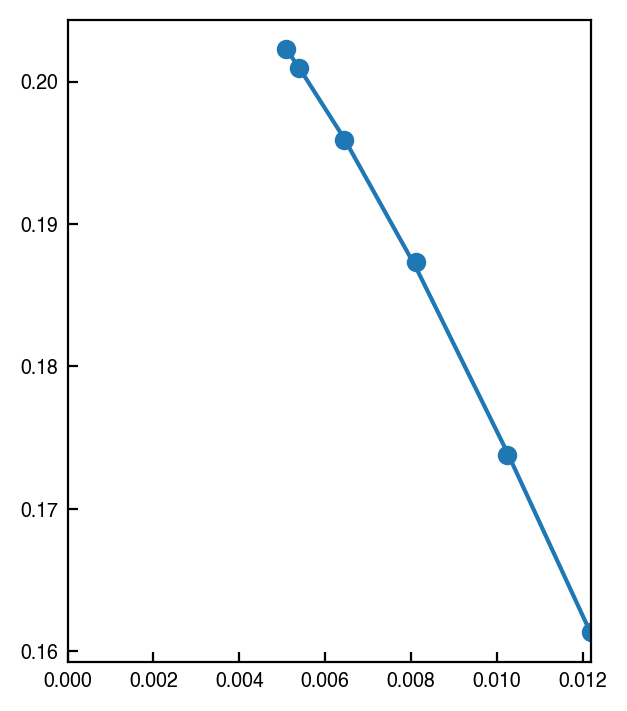

0.0005429869667480808


(-0.029582675390053017, 0.24400878906794896)

In [5]:
index_to_plot = 440
ax_a.vlines(times[index_to_plot],-10, 10, linestyle=":")
ax_a.set_ylim(current_ylims)
for theta_index in indexes:
    ax_bi.scatter(thetas[theta_index], stagmag_averaged[theta_index, index_to_plot], color=colors[theta_index], s=10)
ax_bi.scatter(thetas[theta_index], stagmag_averaged[theta_index, index_to_plot], color=colors[theta_index], label=r"Experimental Points", s=10, zorder=100)

ax_bi.scatter(thetas, stagmag_averaged[:, index_to_plot], s=0.5, label='Numerical Points')

subplot_2_ylims = ax_bi.get_ylim()
ZNE_function = lambda x, y: converge_ZNE_loocv(x, y, debug=True, return_cov=True)

ZNE_function_output, std = ZNE_function(thetas[indexes_mask], stagmag_averaged[:, index_to_plot][indexes_mask])
ZNE_data_plotting = ZNE_function_output(0)
ax_bi.set_xlim([-0.01, max(thetas[indexes_mask])+0.05])
ax_bi.plot(thetas, ZNE_function_output(thetas), color="blue", zorder=-1)#, linestyle="--")
print(std)
ax_bi.errorbar(0, ZNE_data_plotting, yerr=std, color="black", elinewidth=0.5, capsize=2, capthick=0.5)
ax_bi.set_ylim([subplot_2_ylims[0], max(ZNE_function_output(0)+0.03, subplot_2_ylims[1])])

In [6]:
#Baseline error:
baseline_error = np.abs(stagmag_averaged[baseline_index] - stagmag_averaged[0])
ZNE_error = np.abs(ZNE_data - stagmag_averaged[0])

rolling_accumulated_error = np.cumsum(baseline_error)
rolling_accumulated_ZNE = np.cumsum(ZNE_error)
ax_bii.plot(times, rolling_accumulated_error, label="Baseline error", color='black', ls="--")
ax_bii.plot(times, rolling_accumulated_ZNE, label="ZNE error", color="blue")#, ls="--")
ax_bii.set_ylabel(r'Accumulated Error', usetex=1)
ax_bii.set_xlabel(r'Time', usetex=1)
ax_bi.set_ylabel(r'Staggered Magnetization', usetex=1)
ax_a.set_ylabel(r'Staggered Magnetization', usetex=1)
ax_a.set_xlabel(r'Time', usetex=1)
cbar.set_label(r"$\sigma$", labelpad=-20, y=1.12, rotation=0, usetex=1)
ax_bi.set_xlabel(r'Error ($\sigma$)', usetex=1)
ax_a.set_title('PXP Model under Gaussian Noise')


#rolling_max_baseline = np.maximum.accumulate(baseline_error)
#rolling_max_ZNE = np.maximum.accumulate(ZNE_error)
#ax_bii.plot(times, rolling_max_baseline, label="Baseline error", color=colors[baseline_index])
#ax_bii.plot(times, rolling_max_ZNE, label="ZNE error", color="black", ls="--")
#ax_bii.set_yscale("log")
ax_bii.legend()
ax_a.legend()


In [7]:
#ax_a.legend()
fig.tight_layout()
ax_bi.legend()
fig.savefig("Figure_2.pdf", bbox_inches='tight')
fig.savefig("Figure_2.png", bbox_inches='tight', dpi=600)
plt.show()